In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

In [3]:
def generate_average_df(algorithms, data_sets, results_path, output_path): 
    output = {}
    for algorithm in algorithms: 
        output[algorithm] = {}
        for data_set in data_sets: 
            results = pd.read_csv(os.path.join(results_path, algorithm, data_set,'results_table.csv'), header=None)
            results = results[4].values
            output[algorithm][data_set] = str(round(np.mean(results), 3)) + " (" + str(round(np.std(results),3)) +")" 
    output_df = pd.DataFrame.from_dict(output)
    output_df.to_latex(os.path.join(output_path, 'average_f1_table.txt'))

In [21]:
def generate_histograms(algorithms, data_sets, results_path, output_path, data_path):
    output = {}
    for algorithm in algorithms: 
        output[algorithm] = {}
        for data_set in data_sets: 
            files = glob.glob(os.path.join(results_path, algorithm, data_set, '*.json'))
            if not files:
                output[algorithm][data_set] = "N/A"
                continue
            try:
                ARL = []
                for file in files: 
                    with open(file) as f:
                        result = json.load(f)
                    ts_name = result['data_name']
                    detected = np.array(result['cp'])[:, 0]
                    labels = pd.read_csv(os.path.join(data_path, data_set,"{}_labels.csv".format(ts_name)), header=None)
                    labels = labels.values[:,0]
                    for cp in detected:
                        dist = labels-cp
                        index = np.argmin(np.abs(labels-cp))
                        ARL.append(dist[index])
                print(algorithm, data_set, len(ARL))
                output[algorithm][data_set] = str(round(np.mean(np.abs(ARL)), 3)) + " (" + str(round(np.std(np.abs(ARL)), 3)) +"), " + str(round(np.median(np.abs(ARL)), 3)) 
                fig = plt.figure(figsize=(6,4))
                plt.hist(ARL, bins = 20, color = 'g', alpha=0.7)
                plt.title('{} ({})'.format(data_set, algorithm))
                fig.savefig('{}/{}_{}'.format(output_path, data_set, algorithm), dpi = 400)
            except: 
                output[algorithm][data_set] = "N/A"
    output_df = pd.DataFrame.from_dict(output)
    output_df.to_latex(os.path.join(output_path, 'arl_table.txt'))
            
 

binseg struct 57
binseg mean 91
binseg energy 98
binseg yahoo 349
microsoft_ssa struct 112
microsoft_ssa mean 106
microsoft_ssa energy 103
microsoft_ssa yahoo 214
bocpdms struct 217
bocpdms mean 96
bocpdms energy 135
bocpdms yahoo 162
bocpdms hasc 475
klcpd struct 32
klcpd mean 53
klcpd hasc 1
mssa struct 106
mssa mean 86
mssa energy 101
mssa yahoo 272
mssa hasc 242


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


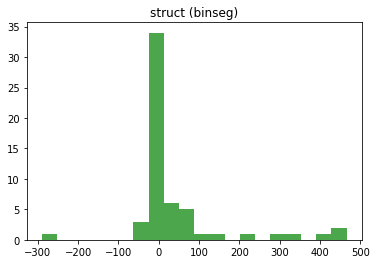

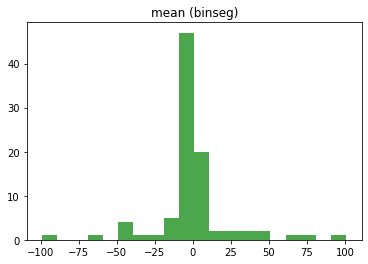

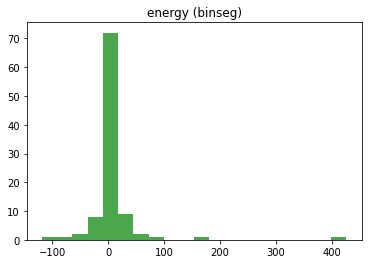

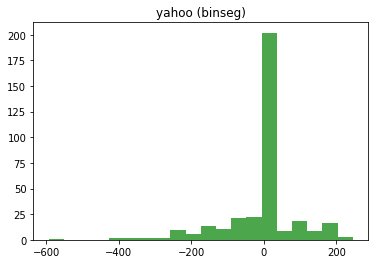

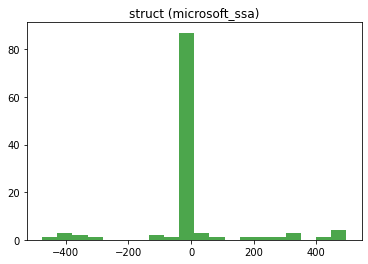

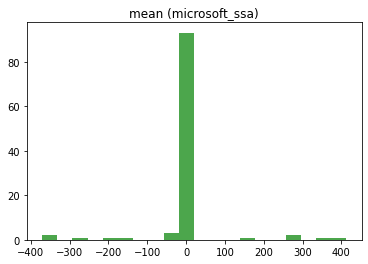

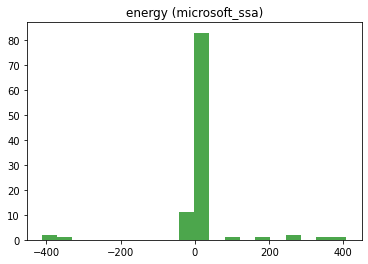

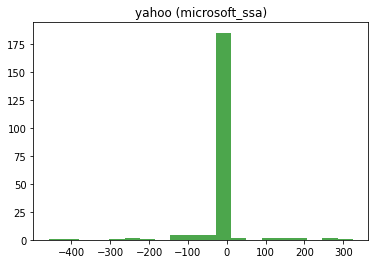

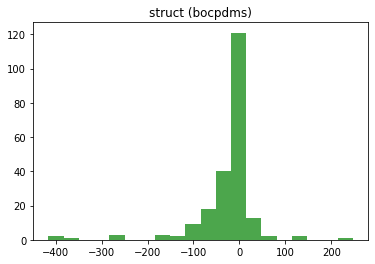

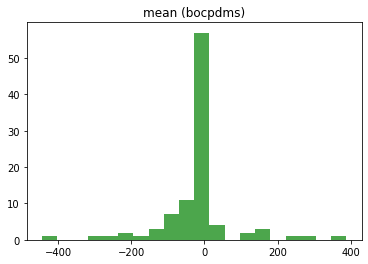

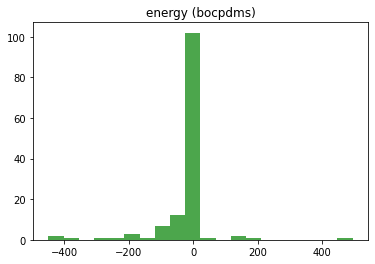

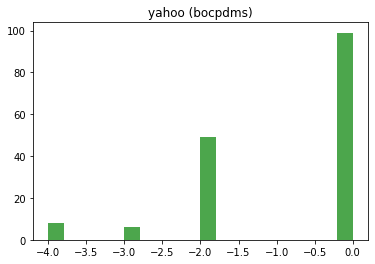

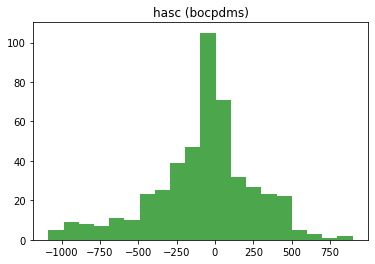

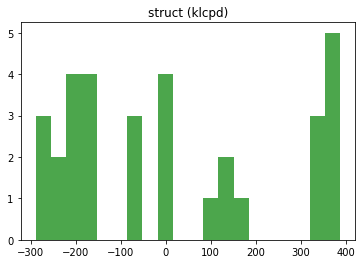

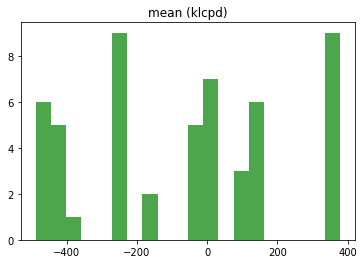

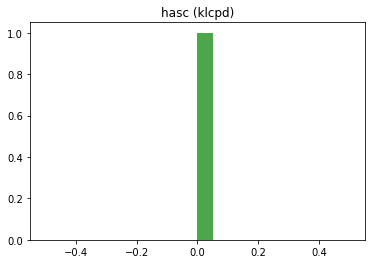

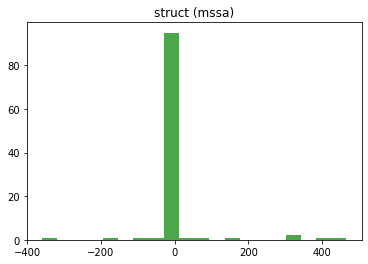

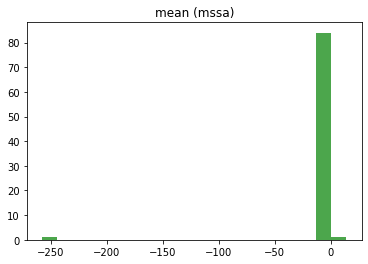

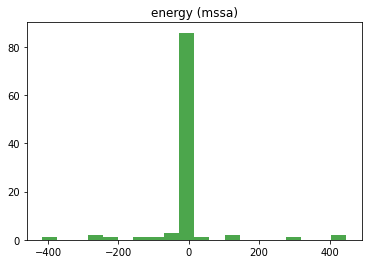

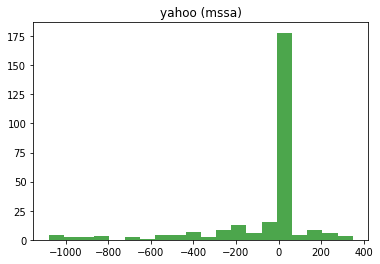

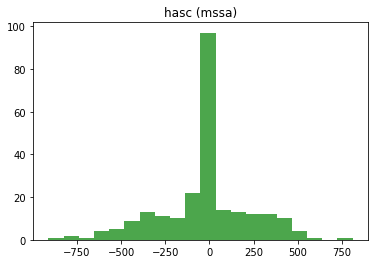

In [23]:
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data')
results_path = os.path.join(os.path.dirname(os.getcwd()), 'test')
output_path = os.path.join(os.path.dirname(os.getcwd()), 'processing')
algorithms = ['binseg', 'microsoft_ssa', 'bocpdms', 'density_ratio', 'klcpd', 'mssa', 'mssa_moving_window']
data_sets = ['struct', 'mean', 'energy', 'yahoo', 'hasc']
# generate_average_df(algorithms, data_sets, results_path, output_path)
generate_histograms(algorithms, data_sets, results_path, output_path, data_path)

In [17]:
files = glob.glob(os.path.join(results_path, algorithms[3], data_sets[0], '*.json'))
files

['/Users/arwaalanqary/Dropbox (MIT)/cpd_benchmark/results/test/density_ratio/hasc/HASC1002_baab6a06-9e40-4404-8de5-280b2e83cedc.json',
 '/Users/arwaalanqary/Dropbox (MIT)/cpd_benchmark/results/test/density_ratio/hasc/HASC1001_ebdf4534-5da4-4e7c-a3fb-339e96c2c8de.json']

In [20]:
for file in files: 
    with open(file) as f:
        result = json.load(f)
    ts_name = result['data_name']
    print(np.array(result['cp']))
    np.array(result['cp'])[:, 0]

[[    0   299]
 [  300   479]
 [  480   826]
 [  827  1942]
 [ 1943  2015]
 [ 2016  4832]
 [ 4833  5999]
 [ 6000  6773]
 [ 6774  8827]
 [ 8828  9240]
 [ 9241 10751]
 [10752 11767]]
[    0 11856]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed